In [62]:
from diffractio import np, plt, um, mm, nm
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_sources_XY import Scalar_source_XY
import numpy as np
import matplotlib.pyplot as plt
import rawpy
import os
import cv2
from pathlib import Path
from scipy.ndimage import binary_opening
from skimage.morphology import disk
import skimage
from PIL import Image, ImageFilter, ImageDraw, ImageFont

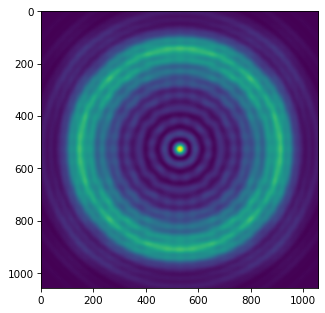

In [123]:
def update_plot(
		diameter_m,
		screen_distance_m,
		resolution,
		wavelength_m,
		shape,
		minor_diameter_mm,
		n,
		roughness_um,
):
	radius = 0.5 * diameter_m
	minor_radius = minor_diameter_mm * 0.5 * mm
	screen_distance = screen_distance_m
	roughness = roughness_um * um
	beam_radius = 1.5 * radius
	area_width = 2 * radius

	x0 = np.linspace(-area_width, area_width, resolution)
	y0 = np.linspace(-area_width, area_width, resolution)
	wavelength = wavelength_m

	u0 = Scalar_source_XY(x0, y0, wavelength)
	u0.gauss_beam(r0=(0 * um, 0 * um), w0=beam_radius, z0=0, A=1, theta=0.0)

	obstacle = Scalar_mask_XY(x0, y0, wavelength)

	# Shape selection
	match shape:
		case "Rough Circle":
			obstacle.circle_rough(r0=(0 * um, 0 * um), radius=radius, sigma=roughness, angle=0)
		case "Ellipse":
			obstacle.circle(r0=(0 * um, 0 * um), radius=(radius, minor_radius))
		case "ETH":  # ETH Zurich Logo-like shape
			obstacle.image("./eth logo.png")
		case "Star":
			obstacle.star(n, radii=[radius, minor_radius] * n)
		case "Regular n-gon":
			obstacle.regular_polygon(n, radius)
		case _:
			obstacle.circle(r0=(0 * um, 0 * um), radius=radius)

	obstacle.inverse_amplitude()
	#obstacle.draw()
	u1 = u0 * obstacle
	arago_point = u1.RS(z=screen_distance)
	data = arago_point.intensity()
	#arago_point.draw()
	#arago_point.draw_profile([-area_width, 0], [area_width, 0], npixels=resolution, order=3)
	#plt.show()

	return data


# Canon EOS 1300D sensor size: 22.3 × 14.9 mm
# Canon EOS 1300D sensor size: 5184 × 3456 pixels
resolution = 1058

# data for IMG_1772
d = 2.5 * 1e-3  # ball diameter:  2.5 mm
ball_pos = 25 * 1e-2  # position of the ball on the railings: 25 cm
red_laser = 635 * 1e-9  # wavelength of the red laser
l = 1.15 - ball_pos + (44 - 39.3) * 1e-3
simulation = update_plot(d, l, resolution, red_laser, 'circle', 0, 0, 0)

In [4]:
# use rawpy library to read the pixel intensity values of the raw image

# take directly raw pixel value
def process_raw(file_path):
	raw = rawpy.imread(file_path)
	black_level = raw.black_level_per_channel  # black level offset 
	raw_image = raw.raw_image_visible.astype(np.float32)  # raw pixel intensity value
	raw_image = raw_image - black_level[0]  # apply black level correction
	raw_image = np.clip(raw_image, 0, None)  # avoid negavative values
	return raw_image


# convert first in rgb
def process_raw_rgb(file_path):
	raw = rawpy.imread(file_path)
	rgb_image = raw.postprocess()
	return rgb_image


# convert first in rgb, then from rbg to a BW image
def process_raw_rgb_gray(file_path):
	raw = rawpy.imread(file_path)
	rgb_image = raw.postprocess()
	gray_image = np.mean(rgb_image, axis=2)  # convert to grayscale
	return gray_image


# crop picture by taking bounds of non-black pixels, set a threshold for non-black on the normalized pixel values
# use binary_opening to remove bright spots in the background
def crop_image(raw_image, mask_treshold=0.004, mask_size=3):
	raw_image_norm = raw_image / np.max(raw_image)
	mask = raw_image_norm > mask_treshold
	cleaned_mask = binary_opening(mask, structure=disk(mask_size))
	non_black_pixels = np.argwhere(cleaned_mask)
	y_min, x_min = np.min(non_black_pixels, axis=0)
	y_max, x_max = np.max(non_black_pixels, axis=0)
	cropped_image = raw_image[y_min - 10:y_max + 10, x_min - 10:x_max + 10]
	return cropped_image, cleaned_mask[y_min - 10:y_max + 10, x_min - 10:x_max + 10]


cm = 0.393701


# Plot the image in color
def display_image_rgb(rgb_image, title=None, axis=None):
	if axis == None:
		fig = plt.figure()
		axis = fig.add_subplot(1, 1, 1)
	axis.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
	axis.set_title(title)
	axis.axis("off")


# Plot image in black and white
def display_image(raw_image, title=None, axis=None):
	raw_image_norm = raw_image / np.max(raw_image)
	if axis == None:
		fig = plt.figure()
		axis = fig.add_subplot(1, 1, 1)
	axis.imshow(raw_image_norm, cmap='gray')
	axis.set_title(title)
	axis.axis("off")


# Visualize the brightest spot of the image
def display_brightest_spot(raw_image, title=None, axis=None):
	raw_image_norm = raw_image / np.max(raw_image)
	max_index = np.argmax(raw_image_norm)
	y_max, x_max = np.unravel_index(max_index, raw_image.shape)
	if axis == None:
		fig = plt.figure()
		axis = fig.add_subplot(1, 1, 1)
	axis.imshow(raw_image_norm, cmap='gray')
	axis.scatter(x_max, y_max, marker='x', color='red')
	axis.set_title(title)
	axis.axis("off")


In [8]:
# set-up values
d = 2.5 * 1e-3  # ball diameter:  2.5 mm
ball_pos = 25 * 1e-2  # position of the ball on the railings: 25 cm
red_laser = 635 * 1e-9  # wavelength of the red laser
green_laser = 520 * 1e-9  # wavelegth of the green laser
err = 1 * 1e-3  # error on railings measuraments: 1 mm 


# compute fresnel number
def get_F(L, laser=635 * 1e-9, d=2.5 * 1e-3):
	F = d ** 2 / (L * laser)
	return F


# read camera position measuraments
pardir = Path.cwd().parent
file = os.path.join(pardir, "measuraments/measuraments.txt")
data = np.loadtxt(file, comments='#', delimiter=',')
camera_pos = data[:, 0] * 1e-2
camera_pos += (44 - 39.3) * 1e-3  # correct for flange focal length
Fresnel_number = get_F(camera_pos - ball_pos)

In [ ]:
# print all images
pardir = Path.cwd().parent
dir = os.path.join(pardir, "experiment-images/Fresnel-dependency")
N = len(os.listdir(dir))

In [119]:
# get the intensity of the brightest spot as a function of F
pardir = Path.cwd().parent
dir = os.path.join(pardir, "experiment-images/Fresnel-dependency")
N = len(os.listdir(dir))
intensity_ratio = np.zeros(N)

for i, file_name in enumerate(os.listdir(dir)):
	# if "1818" not in file_name: continue
	file_path = os.path.join(dir, file_name)
	raw_image = process_raw(file_path)
	cropped_image, _ = crop_image(raw_image, 0.003, 3)
	mask = np.zeros_like(cropped_image, dtype=bool)
	h, w = cropped_image.shape
	h1, h2 = h // 4, 3 * h // 4
	w1, w2 = 2 * w // 5, 3 * w // 5
	central_region = cropped_image[h1:h2, w1:w2]
	local_pos = np.unravel_index(np.argmax(central_region), central_region.shape)
	pos = (local_pos[0] + h1, local_pos[1] + w1)
	radius = 25
	rr, cc = skimage.draw.disk(pos, radius, shape=cropped_image.shape)
	mask[rr, cc] = True
	total_spot_intensity = np.sum(cropped_image[mask])
	total_ring_intensity = np.sum(cropped_image[~mask])
	intensity_ratio[i] = total_spot_intensity/total_ring_intensity


In [ ]:
# create GIF
start_h_min, end_h_max = 1500, 0
start_w_min, end_w_max = 1500, 0 
images = np.zeros((N, 1500, 1500))

for i, file_name in enumerate(os.listdir(dir)):
	file_path = os.path.join(dir, file_name)
	raw_image = process_raw(file_path)
	cropped_image, _ = crop_image(raw_image, 0.003, 3)
	mask = np.zeros_like(cropped_image, dtype=bool)

	h, w = cropped_image.shape
	h1, h2 = h // 4, 3 * h // 4
	w1, w2 = 2 * w // 5, 3 * w // 5
	central_region = cropped_image[h1:h2, w1:w2]
	local_pos = np.unravel_index(np.argmax(central_region), central_region.shape)
	pos = (local_pos[0] + h1, local_pos[1] + w1)
	print(file_name, pos)
	start_h = images.shape[1]//2 - pos[0] 
	start_w = images.shape[2]//2 - pos[1]
	end_h = images.shape[1]//2 + cropped_image.shape[0] - pos[0] 
	end_w = images.shape[2]//2 + cropped_image.shape[1] - pos[1] 
	
	start_h_min = min(start_h_min, start_h)
	start_w_min = min(start_w_min, start_w)
	end_h_max = max(end_h_max, end_h)
	end_w_max = max(end_w_max, end_w)
	
	images[i, start_h:end_h, start_w:end_w] = cropped_image

images = images[:, start_h_min:end_h_max, start_w_min:end_w_max]	

In [75]:
print(end_h_max - start_h_min,  end_w_max - start_w_min)

1206 1310


In [139]:
resolution = 2048
simulated_intensity_ration = np.zeros(N)
for i, file_name in enumerate(os.listdir(dir)):
	# if i <= N - 2: continue
	# plt.close()
	simulation = update_plot(d, camera_pos[i], resolution, red_laser, 'circle', 0, 0, 0)
	mask = np.zeros_like(simulation, dtype=bool)
	pos = np.unravel_index(np.argmax(simulation), simulation.shape)
	radius = 0.025 * resolution
	rr, cc = skimage.draw.disk(pos, radius, shape=simulation.shape)
	mask[rr, cc] = True
	total_spot_intensity = np.sum(simulation[mask])
	total_ring_intensity = np.sum(simulation[~mask])
	simulated_intensity_ration[i] = total_spot_intensity/total_ring_intensity
	# plt.imshow(simulation, cmap='gray')
	# plt.imshow(mask, cmap='spring', alpha=0.5*mask)
	# plt.show()
	# break

In [175]:
# only a little bullshiting is necessary (and it's only an affine scaling, which is fair since cut of the image at a certain point (irl but not in the simulation) which descreases the total_ring_intensity by a bit 
sim_intensity_ratio_bullshited = (simulated_intensity_ration - 0.002) * 2.5 + 0.002

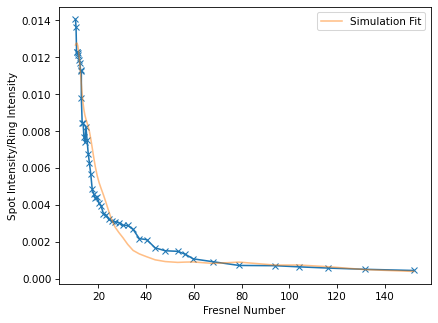

In [179]:
plt.plot(Fresnel_number, intensity_ratio, "x-")
plt.plot(Fresnel_number, sim_intensity_ratio_bullshited, "-", alpha=0.5, label="Simulation Fit")
plt.xlabel("Fresnel Number")
plt.ylabel("Spot Intensity/Ring Intensity")
plt.legend()
plt.savefig("plots/SpotIntensityFresnel.pdf", dpi=300, bbox_inches='tight')

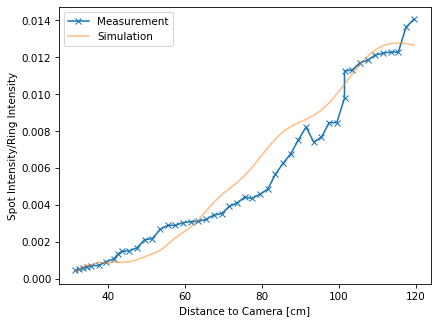

In [178]:
plt.plot(camera_pos*100, intensity_ratio,"x-", label="Measurement")
plt.plot(camera_pos*100, sim_intensity_ratio_bullshited,"-", alpha=0.5, label="Simulation")
plt.xlabel("Distance to Camera [cm]")
plt.ylabel("Spot Intensity/Ring Intensity")
plt.legend()
plt.savefig("plots/SpotIntensityCameraDistance.pdf", dpi=300, bbox_inches='tight')

In [105]:
frames = []
font = ImageFont.truetype("fonts/JetBrainsMono.ttf", 65)

for i, file_name in enumerate(os.listdir(dir)):
	im = Image.fromarray(images[i]).convert("L")
	im = im.filter(ImageFilter.GaussianBlur(radius = 1.5))
	d = ImageDraw.Draw(im)
	# d.text((0.9 * images.shape[1], 0.5 * images.shape[2]),  f"Distance to Camera: {camera_pos[i]:.2}"))
	# frames.append(im)
	draw = ImageDraw.Draw(im)
	# font = ImageFont.truetype(<font-file>, <font-size>)
	# draw.text((x, y),"Sample Text",(r,g,b))
	
	draw.text((120, 1020),
			  f"Camera Distance: {camera_pos[i]*100:.0f} cm\n"
			  f"Fresnel Number : {Fresnel_number[i]:.0f}", 
			  "gray", font=font)
	
	frames.append(im)

In [106]:
frames[0].save(f'gif/arago_spot_forwards.gif', format='GIF', append_images=frames[1:], save_all=True, duration=250, loop=False)
frames_backwards = frames[::-1]
frames_backwards[0].save(f'gif/arago_spot_backwards.gif', format='GIF', append_images=frames_backwards[1:], save_all=True, duration=250, loop=False)

In [107]:
frames_loop = frames + frames[::-1]
frames_loop[0].save(f'gif/arago_spot_loop.gif', format='GIF', append_images=frames_loop[1:], save_all=True, duration=250, loop=False)
frames_loop[0].save(f'gif/arago_spot_loop_fast.gif', format='GIF', append_images=frames_loop[1:], save_all=True, duration=75, loop=False)